In [7]:
%reset

SWG Modelling Library:

Authors: Mustafa Hammood, Ben Cohen-Kleinstein
Affilitation: University of British Columbia (UBC)
Date: 2023-11-14

This jupyter notebook uses Ansys Lumerical Tools to model a sub-wavelength grating (SWG) SOI waveguide.

Current functionality includes:
1. Creates explicit instantiation of a Lumerical tool (valid license and VPN required)
2. Creates an SWG object with the following parameters
    a) Period
    b) Duty Cycle
    c) Fishbone width
    d) Waveguide width / height
    e) Taper dimensions (for 3D-FDTD)

3. Functionality:
    a) SWG FDE modelling using an effective medium
    b) 3D-FDTD bandstructure
    c) Comparing EMT vs. bandstructure
    d) Estimate bulk sensitivity of an SWG based biosensor
    e) 3D-FDTD device simulation

Please familiarize yourself with the code and contact bcohenkl@gmail.com for any errors and requested functionality. Feel free to push your own custom functions into the repo, let's make a great automated SWG modelling software!

In [1]:
import os, sys
import time
import numpy as np
import opticalmaterialspy as mat
import matplotlib
import matplotlib.pyplot as plt
import importlib.util
import subprocess

In [2]:
########################################################
#### Load Lumerical with an Explicit Instantiation #####
########################################################

# Ensure you have a valid lumerical license and that your cisco VPN is ON

# Locate the Lumerical API (WINDOWS - UNTESTED FOR MAC) - YOU MIGHT HAVE TO CHANGE
start_path = ["C:\\Program Files\\Lumerical\\"]
lumapi_path = None

# Iterate through paths to find lumapi.py
for base_path in start_path:
    if os.path.exists(base_path):
        for folder in os.listdir(base_path):
            potential_path = os.path.join(base_path, folder, 'api', 'python', 'lumapi.py')
            if os.path.exists(potential_path):
                lumapi_path = potential_path
                break

# Load lumapi.py explicitly
if lumapi_path:
    spec = importlib.util.spec_from_file_location('lumapi', lumapi_path)
    lumapi = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(lumapi)
    print("Lumapi module loaded successfully.")

    # Initialize an FDTD session to test that it works
    try:
        fdtd = lumapi.FDTD()
        print("FDTD session started successfully.")
    finally:
        if 'fdtd' in locals():
            fdtd.close()
            print("FDTD session closed.")
else:
    print("Could not find lumapi.py at the specified path")

Lumapi module loaded successfully.
FDTD session started successfully.
FDTD session closed.


<ipython-input-3-1b4720cfd42c>:747: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


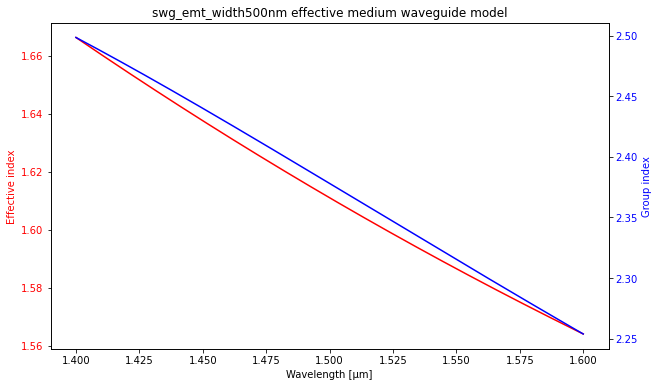

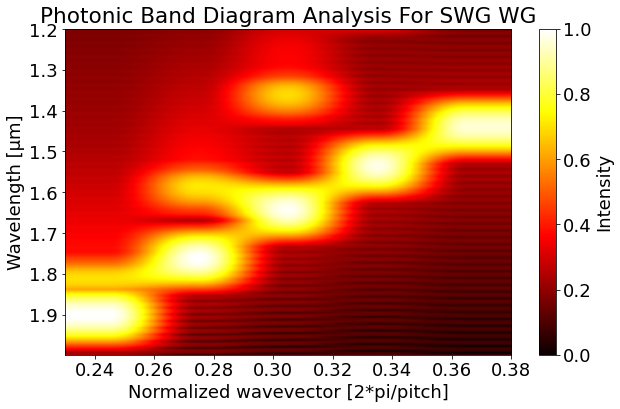

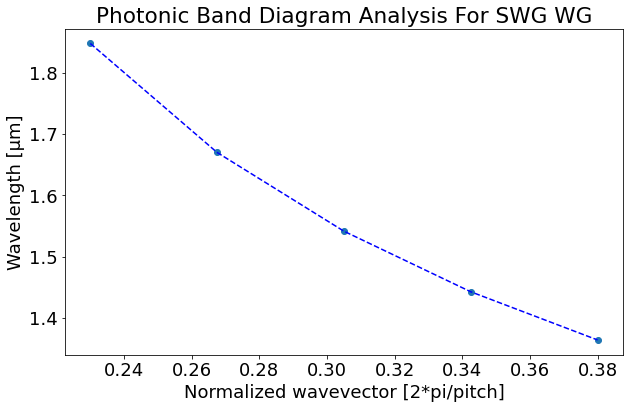

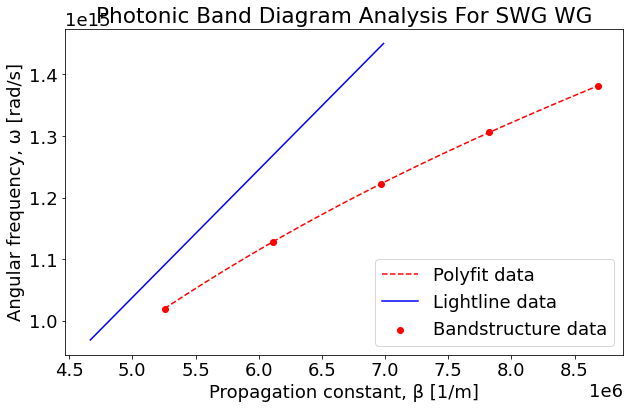

<ipython-input-3-1b4720cfd42c>:521: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-3-1b4720cfd42c>:784: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


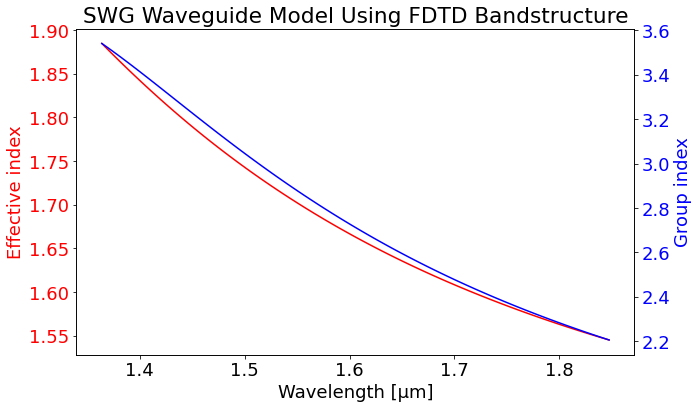

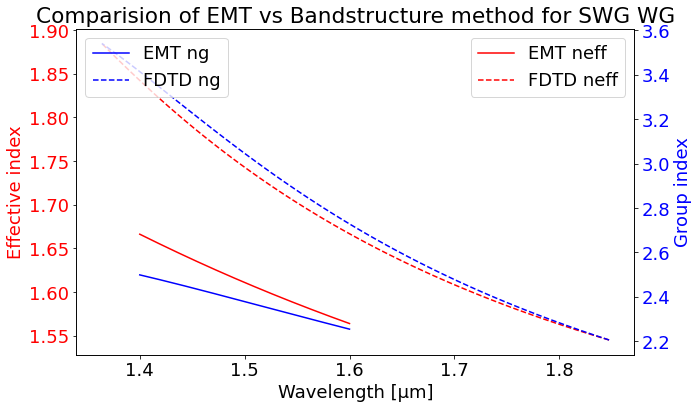

In [3]:
class swg_model_library:
    """  
    SWG Modelling Library
    Authors: Mustafa Hammood (UBC), Ben Cohen-Kleinstein (UBC)
    
    Functions:
        1. bandstructure():              
            - 3D-FDTD Bandstructure analysis on a SWG 
        2. swg_emt():                   
            - Mode solver of a effective-medium SWG over a frequency band
        3. compare_emt_bandstructure(): 
            - Compare EMT SWG vs. 3D-FDTD Bandstructure Sim
        4. simulate_fdtd():             
            - 3D-FDTD simulation of an overall SWG waveguide with I/O tapers
        5. bulk_sensitivity(dn, num_steps, wvl):           
            - Calculates the change in neff for a change in bulk refractive index - bandstructure
            Inputs:
              a) dn: The total change in RIU
              b) num_steps: The number of increments from the first refractive index
              c) wvl: Wavelength of interest
            -Note: Only works for SiO2 (which is counterintuitive yes) and Air. Water will be added at a later date
            -This is for straight waveguides only
    """

    def __init__(
        self,
        width_wg,
        width_wg_taper_tip,
        width_fishbone,
        width_wg_port,
        swg_pitch,
        swg_dc,
        length_swg_taper,
        
        thickness_cladding,
        thickness_BOX,
        thickness_device,
        thickness_substrate,

        mat_cladding,
        mat_BOX,
        mat_device,
        mat_substrate,
        
        wavl_start,
        wavl_stop,
    ):
        """
        initialization method. All units are SI.

        Parameters
        ----------
        width_wg : float
            SWG waveguide width.
        width_fishbone : float
            SWG fishbone waveguide width.
        swg_pitch : float
            Sub wavelength period.
        swg_dc : float
            Sub wavelength duty cylce. value from 0 to 1.
        length_swg_taper : float
            Strip-subwavelength taper length.
        
        thickness_cladding: float
            Cladding thickness
        thickness_BOX: float
            Buried oxide thickness
        thickness_device : float
            Device layer thickness.
        thickness_substrate : float
            Substrate layer thickness.

        mat_caldding: string
            Cladding layer material name
        mat_BOX: string
            Buried oxide layer material name
        mat_device : string
            Device layer material name.
        mat_substrate : string
            Substrate layer material name.
        
        wavl_start: float
            Wavelength Start Point
        wavl_stop: float
            Wavelength Stop Point
        Returns
        -------
        None.

        """
        self.width_wg = width_wg
        self.width_wg_taper_tip = width_wg_taper_tip
        self.width_fishbone = width_fishbone
        self.width_wg_port = width_wg_port
        self.swg_pitch = swg_pitch
        self.swg_dc = swg_dc
        self.length_swg_taper = length_swg_taper
        
        self.thickness_cladding = thickness_cladding
        self.thickness_BOX = thickness_BOX
        self.thickness_device = thickness_device
        self.thickness_substrate = thickness_substrate

        self.mat_cladding = mat_cladding
        self.mat_BOX =  mat_BOX
        self.mat_device = mat_device
        self.mat_substrate = mat_substrate
    
        self.wavl_start = wavl_start
        self.wavl_stop = wavl_stop

    @property
    def device_id(self):
        return f"swg_af_WGA{int(self.width_wg*1e9)}"
    
    def bandstructure(
        self,
        mesh=2,
        finemesh_y = 20e-9,
        finemesh_z = 20e-9,
        sim_time = 500e-15,

        f1 = 150e12,
        f2 = 250e12,
        kx_start = 0.23,
        kx_stop = 0.38,
        kx_pts = 5,

        apod_center = 0.5,
        apod_width = 0.125,

        visual = True,
        sb_analysis = False, # Custom bulk refractive index  
        sb_n = 0,
        
    ):
        """
        Simulate the SWG waveguide using FDTD bloch-boundary bandstructure method.
        Note: Sensitive to f1/f2 and kx range. Multiple iterations might be needed to determine correct values

        Parameters
        ----------
        mesh : int, optional
            FDTD overall solver mesh accuracy (1-8). The default is 2.
        finemesh_y : float, optional
            Fine mesh region (y) around the waveguide step size. The default is 20e-9.
        finemesh_z : TYPE, optional
            Fine mesh region (z) around the waveguide the waveguide step size. The default is 20e-9.
        sim_time : float, optional
            FDTD simulation time. The default is 501e-15.
        f1 : float, optional
            Frequency start point. The default is 150e12.
        f2 : float, optional
            Frequency stop point. The default is 250e12.
        kx_start : float, optional
            Normalized wavevector start. The default is 0.2.
        kx_stop : float, optional
            Normalized wavevector stop. The default is .38.
        kx_pts : int, optional
            Number of wavevector points in the bandstructure. The default is 5.
        apod_center : float, optional
            Inverse fourier transform's normalized apodization center. The default is 0.5.
        apod_width : float, optional
            Inverse fourier transform's normalized apodization width. The default is 0.125.
        visual : Boolean, optional
            Visualization flag. The default is True.
        sb_analysis: Boolean, optional
            True when the bulk sensitivity analysis is run  
        sb_n:
            Refractive index of the cladding

        Returns
        -------
        None

        """

        # FDTD parameters
        x_span = self.swg_pitch*4 + 2e-6
        y_span = self.width_wg + 3e-6
        y_span_fdtd = y_span
        
        with lumapi.FDTD(hide=False) as fdtd:
            
            # If bulk sensitivity analysis
            if (sb_analysis):
                self.mat_cladding = self.custom_mat(fdtd, "material_" + str(sb_n), sb_n)            
            
            # add materials
            self.add_material(fdtd)
            
            # Add structures

            # Cladding:
            fdtd.addrect()
            fdtd.set("name", "cladding")
            fdtd.set("material", self.mat_cladding)
            fdtd.set("x", 0)
            fdtd.set("x span", x_span)
            fdtd.set("z min", 0)
            fdtd.set("z max", self.thickness_cladding)
            fdtd.set("y", 0)
            fdtd.set("y span", y_span)
            fdtd.set("override mesh order from material database", 1)
            fdtd.set("mesh order", 3)
            fdtd.set("alpha", 0.2)

            # Buried Oxide:
            fdtd.addrect()
            fdtd.set("name", "BOX")
            fdtd.set("material", self.mat_BOX)
            fdtd.set("x", 0)
            fdtd.set("x span", x_span)
            fdtd.set("z min", -self.thickness_BOX)
            fdtd.set("z max", 0)
            fdtd.set("y", 0)
            fdtd.set("y span", y_span)
            fdtd.set("override mesh order from material database", 1)
            fdtd.set("mesh order", 3)
            fdtd.set("alpha", 0.2)

            # Substrate
            fdtd.addrect()
            fdtd.set("name", "substrate")
            fdtd.set("material", self.mat_substrate)
            fdtd.set("x", 0)
            fdtd.set("x span", x_span)
            fdtd.set("z min", -(self.thickness_substrate + self.thickness_BOX))
            fdtd.set("z max", -self.thickness_BOX)
            fdtd.set("y", 0)
            fdtd.set("y span", y_span)
            fdtd.set("override mesh order from material database", 1)
            fdtd.set("mesh order", 3)
            fdtd.set("alpha", 0.2)
            
            # Fishbone
            if self.width_fishbone > 0:
                fdtd.addrect()
                fdtd.set("name", "fishbone")
                fdtd.set("material", self.mat_device)
                fdtd.set("x", 0)
                fdtd.set("x span", x_span)
                fdtd.set("z min", 0)
                fdtd.set("z max", self.thickness_device)
                fdtd.set("y", 0)
                fdtd.set("y span", self.width_fishbone)

            # SWG
            x0 = -2 * self.swg_pitch - self.swg_dc*self.swg_pitch/2
            n_swg = 4
            for i in range(n_swg):
                fdtd.addrect()
                fdtd.set("name", f"swg{i}")
                fdtd.set("material", self.mat_device)
                fdtd.set("x min", x0 + i * self.swg_pitch)
                fdtd.set(
                    "x max", x0 + i * self.swg_pitch + self.swg_pitch * self.swg_dc
                )
                fdtd.set("z min", 0)
                fdtd.set("z max", self.thickness_device)
                fdtd.set("y", 0)
                fdtd.set("y span", self.width_wg)
                fdtd.set("override mesh order from material database", 1)
                fdtd.set("mesh order", 1)
                

            # build simulation and sweep
            fdtd.addfdtd()
            fdtd.set("mesh accuracy", mesh)  # 2 is usually okay for >1.4µm
            fdtd.set("simulation time", sim_time)  # 500 fs seems converging
            fdtd.set("x min", -self.swg_pitch/2)
            fdtd.set("x max", self.swg_pitch/2)
            fdtd.set("y", 0)
            fdtd.set("y span", y_span_fdtd)
            fdtd.set("z min", -6*self.thickness_device)  # convergence TBD
            fdtd.set("z max", 6*self.thickness_device)
            
            fdtd.set("x min bc", "Bloch")
            fdtd.set("y min bc", "PML")
            fdtd.set("y max bc", "PML")
            fdtd.set("z min bc", "PML")
            fdtd.set("z max bc", "PML")
            fdtd.set("set based on source angle", 0)

            # add fine mesh
            fdtd.addmesh()
            fdtd.set("x min", -self.swg_pitch/2)
            fdtd.set("x max", self.swg_pitch/2)
            fdtd.set("y", 0)
            fdtd.set("y span", 1.5 * self.width_wg)
            fdtd.set("z", self.thickness_device / 2)
            fdtd.set("z span", 2 * self.thickness_device)
            fdtd.set("override x mesh", False)
            fdtd.set("dy", finemesh_y)
            fdtd.set("dz", finemesh_z)

            # add source (mode source vs. plane source? identical results)
            fdtd.addplane()
            fdtd.set("injection axis", "x-axis")
            fdtd.set("x", 0)
            fdtd.set("y", 0)
            
            # not sure why the sent val is multiplied by 2!
            fdtd.set("y span", y_span_fdtd)
            fdtd.set("z", self.thickness_device/2)  # convergence TBD
            fdtd.set("z span", self.thickness_device*6)
            fdtd.set("frequency start", f1)
            fdtd.set("frequency stop", f2)

            # add bandstructure object
            fdtd.addobject("bandstructure")
            fdtd.set("x", 0)
            fdtd.set("x span", self.swg_pitch)
            
            fdtd.set("y", 0)
            fdtd.set("y span", 1.5 * self.width_wg)
            fdtd.set("z", self.thickness_device / 2)
            fdtd.set("z span", 2 * self.thickness_device)
            
            # modify the bandstructure object analysis script because
            # lumerical changed it and the analysis broke in 2020...
            fdtd.addanalysisprop("apod_width", 0, apod_width)
            fdtd.addanalysisprop("apod_center", 0, apod_center)

            analysisscript = """
            # simplify variable names by removing spaces
            apod_width = %apod_width%;
            apod_center = %apod_center%;
            n_monitors = %n monitors%;

            # don't allow f1=0, as this causes a minor problem:  f=0 corresponds to lambda=infinity, and the infinity causes problems in the data visualizer.
            if (f1<=0) { f1 = f2/10000; }

            t = getdata("m1","t");
            fs = 0;

            # loop over each time monitor
            for(j=1:n_monitors) {
              for (component_i=1:3) { # loop over field components
                if (component_i==1) { component="Ex"; }
                if (component_i==2) { component="Ey"; }
                if (component_i==3) { component="Ez"; }

                # collect the field data
                signal = pinch(getdata("m"+num2str(j),component));

                # apodize the signal with a gaussian, to ignore start and end effects
                signal = signal*exp( - 0.5*(t-max(t)*apod_center)^2/(apod_width*max(t))^2);

                # fft the time signal and add it to the other fft's
                f = linspace(f1,f2,5000);
                fs = fs + abs(czt(signal,t,2*pi*f))^2;
              }
            }

            # create data set
            spectrum = matrixdataset("spectrum");
            # in most cases, lambda is before f in datasets.  However, for this particular application, frequency is far more common, so it is first.
            spectrum.addparameter("f",f,"lambda",c/f);
            spectrum.addattribute("fs",fs);

            peaks = findpeaks(fs,2);
            lambda1 = c/f(peaks(1));
            lambda2 = c/f(peaks(2));
            lambda_center = (lambda1+lambda2)/2;
            delta_lambda = abs(lambda2-lambda1);
            """

            fdtd.set("analysis script", analysisscript)

            # setup model object
            fdtd.select("")  # selects top level "model"
            fdtd.adduserprop("pitch", 2, self.swg_pitch)
            fdtd.adduserprop("apod_center", 0, apod_center)
            fdtd.adduserprop("apod_width", 0, apod_width)
            fdtd.adduserprop("f1", 4, f1)
            fdtd.adduserprop("f2", 4, f2)
            fdtd.adduserprop("kx", 0, 0.4)
            model_script = 'setnamed("FDTD","x span", pitch);\n'
            model_script += 'setnamed("FDTD","bloch units","SI");\n'
            model_script += 'setnamed("FDTD","kx",kx*2*pi/pitch);\n'
            model_script += 'name="bandstructure";\n'
            model_script += 'setnamed(name,"x span",pitch);\n'
            model_script += 'setnamed(name,"f1",f1);\n'
            model_script += 'setnamed(name,"f2",f2);\n'
            model_script += 'setnamed(name,"apod_center",apod_center);\n'
            model_script += 'setnamed(name,"apod_width",apod_width);\n'
            fdtd.set("setup script", model_script)

            # add sweep object and a parameter
            fdtd.addsweep()
            kx = dict()
            kx["Name"] = "kx"
            kx["Parameter"] = "::model::kx"
            kx["Type"] = "Number"
            kx["Start"] = kx_start
            kx["Stop"] = kx_stop
            fdtd.addsweepparameter("sweep", kx)

            spectrum = dict()
            spectrum["Name"] = "spectrum"
            spectrum["Result"] = "::model::bandstructure::spectrum"
            fdtd.addsweepresult("sweep", spectrum)

            fdtd.setsweep("sweep", "number of points", kx_pts)

            # run sweep
            swg_wg_id = (
                f"swg_width{int(1e9*self.width_wg)}nm_pitch{int(1e9*self.swg_pitch)}nm"
            )
            fdtd.save(swg_wg_id)
            fdtd.runsweep("sweep")

            # extract data and analyze
            spectrum = fdtd.getsweepresult("sweep", "spectrum")
            kx = spectrum["kx"][0]
            f = spectrum["f"]
            fs = np.log10(spectrum["fs"])
            beta = kx * 2 * np.pi / self.swg_pitch
            c = 299792458  # m/s

            fband = []
            for i in range(len(kx)):
                peak_pos = np.argmax(np.abs(np.transpose(fs)[i]))
                fband.append(f[peak_pos][0])

            # fit and resample on higher resolution
            N = 3  # fit order
            npts = 100  # resampling points
            w = 2 * np.pi * np.array(fband)
            p = np.flip(np.polyfit(beta, w, N))
            beta_resample = np.linspace(min(beta), max(beta), npts)
            w_resample = p[0]

            for i in range(1, len(p)):
                w_resample = w_resample + p[i] * beta_resample ** [i]

            lightline_w = np.linspace(
                0.95 * np.min(w_resample), 1.05 * np.max(w_resample), npts
            )
            n_substrate = fdtd.getfdtdindex(
                self.mat_cladding, lightline_w / (2 * np.pi), np.min(f), np.max(f)
            )

            v_phase = w_resample / beta_resample  # phase velocity
            # sample dw/dbeta to get the group velocity
            dw_dbeta = p[1]
            for i in range(2, len(p)):
                dw_dbeta = dw_dbeta + p[i] * i * beta_resample ** [i - 1]
            v_group = dw_dbeta

            # calculate neff and ng
            self.swg_neff = c / v_phase
            self.swg_ng = c / v_group

            f_resample = w_resample / (2 * np.pi)
            self.swg_wavl = c / f_resample
            if visual:
                font = {"family": "normal", "size": 18}

                matplotlib.rc("font", **font)
                # plot raw bandstructure
                # Let's make sure that 'fs' is normalized to [0, 1] before displaying it.
                fs_normalized = (fs - fs.min()) / (fs.max() - fs.min())

                plt.figure(figsize=(10, 6))
                plt.imshow(
                    fs_normalized,
                    origin="lower",
                    aspect="auto",
                    cmap="hot",
                    extent=[kx.min(), kx.max(), 1e6 * c / f.min(), 1e6 * c / f.max()],
                )
                plt.colorbar(label="Intensity")
                plt.title("Photonic Band Diagram")
                plt.xlabel("Normalized wavevector [2*pi/pitch]")
                plt.ylabel("Wavelength [µm]")
                plt.title("Photonic Band Diagram Analysis For SWG WG")
                plt.savefig(f"banstructure_{swg_wg_id}")
                plt.show()

                plt.figure(figsize=(10, 6))
                plt.scatter(kx, 1e6 * c / np.array(fband))
                plt.plot(kx, 1e6 * c / np.array(fband), "--", color="blue")
                plt.xlabel("Normalized wavevector [2*pi/pitch]")
                plt.ylabel("Wavelength [µm]")
                plt.title("Photonic Band Diagram Analysis For SWG WG")
                plt.savefig(f"wavevector_{swg_wg_id}")
                plt.show()

                lightline_beta = lightline_w * np.real(n_substrate) / c
                lightline_beta = lightline_beta[0]
                plt.figure(figsize=(10, 6))
                plt.scatter(beta, w, color="red", label="Bandstructure data")
                plt.plot(
                    beta_resample, w_resample, "--", color="red", label="Polyfit data"
                )
                plt.plot(
                    lightline_beta, lightline_w, color="blue", label="Lightline data"
                )
                plt.xlabel("Propagation constant, β [1/m]")
                plt.ylabel("Angular frequency, ω [rad/s]")
                plt.title("Photonic Band Diagram Analysis For SWG WG")
                plt.legend()
                plt.savefig(f"lightline_{swg_wg_id}")
                plt.show()

                fig, ax1 = plt.subplots(figsize=(10, 6))
                ax1.plot(self.swg_wavl * 1e6, self.swg_neff, color="r")
                ax1.set_ylabel("Effective index", color="r")
                ax1.set_xlabel("Wavelength [µm]")
                ax1.set_title("SWG Waveguide Model Using FDTD Bandstructure")
                for tl in ax1.get_yticklabels():
                    tl.set_color("r")
                ax2 = ax1.twinx()
                ax2.plot(self.swg_wavl * 1e6, self.swg_ng, color="b")
                ax2.set_ylabel("Group index", color="b")
                for tl in ax2.get_yticklabels():
                    tl.set_color("b")
                fig.savefig(f"neff_ng_{swg_wg_id}")
                fig.show()

    def swg_emt(
        self,
        npts=500,
        visual=True,
        mesh_dx=50e-9,
        mesh_dy=50e-9,
        mode_npts=5,
    ):
        """
        Model an SWG waveguide using the effective medium theory method.

        Parameters
        ----------
        mesh_dx : float, optional
            X Mesh step in the eigenment solver. The default is 25e-9.
        mesh_dy : float, optional
            Y Mesh step in the eigenment solver. The default is 25e-9.
        wavl_start : float, optional
            Wavelength sweep start point. The default is 1.4e-6.
        wavl_stop : float, optional
            Wavelength sweep stop point. The default is 1.7e-6.
        npts : int, optional
            EMT model wavelength points. The default is 500.
        mode_npts : TYPE, optional
            Wavelength sweep points. The default is 5.
        visual : Boolean, optional
            Visualization flag. The default is True.


        Returns
        -------
        None.

        """

        # Si Li model 1980 (1.2 µm - 14 µm) - 293 K (couldn't get Palik...)
        Si = mat.RefractiveIndexWeb(
            "https://refractiveindex.info/?shelf=main&book=Si&page=Li-293K"
        )
        SiO2 = mat.SiO2()

        vol_dev = self.swg_dc
        vol_clad = 1 - self.swg_dc

        self.wavl_emt = np.linspace(self.wavl_start, self.wavl_stop, npts)
        self.swg_n_emt = []
        for i in self.wavl_emt:
            # TODO: add fishbone effect
            self.swg_n_emt.append(
                Si.n(i) * vol_dev / (vol_dev + vol_clad) + SiO2.n(i) * vol_clad
            )

        # calculate group index (irrelevant...)
        self.swg_ng_emt = []
        for i in self.wavl_emt:
            self.swg_ng_emt.append(
                Si.ng(i) * vol_dev / (vol_dev + vol_clad)
                + SiO2.ng(i) * vol_clad / (vol_dev + vol_clad)
            )

        swg_emt_id = f"swg_emt_width{int(1e9*self.width_wg)}nm"


        # Create an equivalent material model in lumerical
        # export material
        # Create an array with zeros for the third column (imaginary)
        zeros = np.zeros_like(self.wavl_emt)
        
        # Combine the variables into a single array
        data = np.column_stack((self.wavl_emt * 1e9, self.swg_n_emt, zeros))
        
        # Define the filename for the text file
        filename = f"{swg_emt_id}_material.txt"
        
        # Save the data to a text file
        np.savetxt(filename, data, delimiter="\t", fmt="%.6f")

        sim_buffer_y = 0.1e-6  # buffer between material and sim region
        x_span = self.width_wg * 8 + 2e-6
        x_span_fde = x_span - 2 * sim_buffer_y
        y_span = self.thickness_device + 8e-6
        y_span_fde = y_span - 2 * sim_buffer_y
        z_span = 1e-6  # irrelevent

        with lumapi.MODE(hide=False) as mode:
            self.add_material(mode)
            
            # add material
            mode.eval("swg_material = addmaterial('Sampled 3D data');")
            mode.eval(f"setmaterial(swg_material, 'name', '{swg_emt_id}');")
            # format the data for lumerical's silly format
            c = 299792458  # m/s
            wavl_arr = np.array2string(c / self.wavl_emt, separator=";").replace(
                "\n", ""
            )
            n_arr = np.array2string(
                np.array(self.swg_n_emt) ** 2, separator=";"
            ).replace("\n", "")
            mode.eval(
                f"setmaterial('{swg_emt_id}', 'sampled 3d data', [{wavl_arr},{n_arr}]);"
            )
            
            # Buried Oxide
            mode.addrect()
            mode.set("name", "BOX")
            mode.set("material", self.mat_BOX)
            mode.set("x", 0)
            mode.set("x span", 10e-6)
            mode.set("y", 0)
            mode.set("y span", 10e-6)
            mode.set("z min", -self.thickness_BOX)
            mode.set("z max", 0)
            mode.set("override mesh order from material database", 1)
            mode.set("mesh order", 3)

            # Cladding
            mode.addrect()
            mode.set("name", "Cladding")
            mode.set("material", self.mat_cladding)
            mode.set("x", 0)
            mode.set("x span", 10e-6)
            mode.set("y", 0)
            mode.set("y span", 10e-6)
            mode.set("z min", 0)
            mode.set("z max", self.thickness_cladding)
            mode.set("override mesh order from material database", 1)
            mode.set("mesh order", 3)
            mode.set("alpha", 0.2)

            # Waveguide
            mode.addrect()
            mode.set("name", "Waveguide")
            mode.set("material", swg_emt_id)
            mode.set("x", 0)
            mode.set("x span", self.width_wg)
            mode.set("y", 0)
            mode.set("y span", 10e-6)
            mode.set("z min", 0)
            mode.set("z max", self.thickness_device)
            mode.set("override mesh order from material database", 1)
            mode.set("mesh order", 1)

            # Add the Mode Solver and define mesh size, boundary conditions
            mode.addfde()
            mode.set('solver type', '2D Y normal')
            mode.set("x", 0)
            mode.set("x span", 8e-6)
            mode.set("y", 0)
            mode.set("z min", -1e-6)
            mode.set("z max", 1e-6)

            mode.set("define x mesh by", "maximum mesh step")
            mode.set("define z mesh by", "maximum mesh step")
            mode.set("dx", mesh_dx)
            mode.set("dz", mesh_dy)
            
            mode.set("x min bc", "Metal")
            mode.set("x max bc", "Metal")
            mode.set("z min bc", "Metal")
            mode.set("z max bc", "Metal")
            
            # Frequency Analysis to find dispersion (neff and ng dependence on wavelength)
            mode.run()
            mode.setanalysis("wavelength", self.wavl_start)
            mode.setanalysis("stop wavelength", self.wavl_stop)
            mode.setanalysis("number of points", mode_npts)
            mode.setanalysis("number of trial modes", 1)

            mode.findmodes()
            mode.selectmode(1)
            mode.setanalysis("track selected mode", 1)
            mode.setanalysis("detailed dispersion calculation", 1)
            mode.frequencysweep()

            f = mode.getdata("frequencysweep", "f_D")
            f = [i[0] for i in f]
            wavl = c / np.array(f)

            vg = np.abs(mode.getdata("frequencysweep", "vg"))
            vg = [i[0] for i in vg]

            ng = c / np.array(vg)
            neff = np.abs(mode.getdata("frequencysweep", "neff"))
            neff = [i[0] for i in neff]


            # Curve fit to neff, ng with a polynomial of N = 3
            N = 3  # fit order
            pts = npts  # resampling points

            wavl_poly_coeffs = np.polyfit(np.arange(len(wavl)), wavl, deg=N)
            self.swg_emt_wavl = np.polyval(
                wavl_poly_coeffs, np.linspace(0, len(wavl) - 1, pts)
            )

            ng_poly_coeffs = np.polyfit(np.arange(len(ng)), ng, deg=N)
            self.swg_emt_ng = np.polyval(
                ng_poly_coeffs, np.linspace(0, len(ng) - 1, pts)
            )

            neff_poly_coeffs = np.polyfit(np.arange(len(neff)), neff, deg=N)
            self.swg_emt_neff = np.polyval(
                neff_poly_coeffs, np.linspace(0, len(neff) - 1, pts)
            )

            if visual:
                import matplotlib.pyplot as plt
                import matplotlib

                font = {"family": "normal", "size": 18}

                fig, ax1 = plt.subplots(figsize=(10, 6))
                ax1.plot(self.swg_emt_wavl * 1e6, self.swg_emt_neff, color="r")
                ax1.set_ylabel("Effective index", color="r")
                ax1.set_xlabel("Wavelength [µm]")
                ax1.set_title(f"{swg_emt_id} effective medium waveguide model")
                for tl in ax1.get_yticklabels():
                    tl.set_color("r")
                ax2 = ax1.twinx()
                ax2.plot(self.swg_emt_wavl * 1e6, self.swg_emt_ng, color="b")
                ax2.set_ylabel("Group index", color="b")
                for tl in ax2.get_yticklabels():
                    tl.set_color("b")
                fig.savefig(f"neff_ng_{swg_emt_id}")
                fig.show()
        
    
    def compare_emt_banstructure(self):
        """
        Method to visualize the difference between EMT and FDTD methods for
        simulating a sub-wavelength waveguide.

        Returns
        -------
        None.

        """

        font = {"family": "normal", "size": 18}

        self.swg_emt()
        self.bandstructure()

        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(
            self.swg_emt_wavl * 1e6, self.swg_emt_neff, color="r", label="EMT neff"
        )
        ax1.plot(self.swg_wavl * 1e6, self.swg_neff, "--", color="r", label="FDTD neff")
        ax1.set_ylabel("Effective index", color="r")
        ax1.set_xlabel("Wavelength [µm]")
        ax1.set_title(f"Comparision of EMT vs Bandstructure method for SWG WG")
        ax1.legend(loc=1)
        for tl in ax1.get_yticklabels():
            tl.set_color("r")
        ax2 = ax1.twinx()
        ax2.plot(self.swg_emt_wavl * 1e6, self.swg_emt_ng, color="b", label="EMT ng")
        ax2.plot(self.swg_wavl * 1e6, self.swg_ng, "--", color="b", label="FDTD ng")
        ax2.set_ylabel("Group index", color="b")
        for tl in ax2.get_yticklabels():
            tl.set_color("b")
        ax2.legend(loc=2)
        fig.show()

    
    def simulate_fdtd(
        self, mesh=2, wavl_pts=301, visual=True
    ):

        sim_buffer = 0.2e-6  # buffer between material and sim region
        pml_buffer = 4e-6  # distance buffer between waveguide and sim edge

        z_span = self.thickness_device + 4e-6
        z_span_sim = z_span - 2 * sim_buffer
        y_span_sim = self.width_wg + 2 * pml_buffer
        y_span = y_span_sim + 2 * sim_buffer
        y_span_port = (
            4 * self.width_wg_port
        )
        y = 0  # y center point of the simulation, substate, and cladding
        y_dev = y + 1.5e-6

        x0 = 0
        x1 = x0 + self.length_swg_taper
        x2 = x1
        x3 = x2
        x4 = x3
        x5 = x4 + self.length_swg_taper
        x_end = x5

        with lumapi.FDTD(hide=False) as fdtd:
            self.add_material(fdtd)
            
            # Step 1: build geometry
            fdtd.addrect()
            fdtd.set("name", "substrate")
            fdtd.set("material", self.mat_cladding)
            fdtd.set("x min", x0 - sim_buffer)
            fdtd.set("x max", x_end + sim_buffer)
            fdtd.set("y", y)
            fdtd.set("y span", y_span + sim_buffer)
            fdtd.set("z max", 0)
            fdtd.set("z min", -self.thickness_substrate)
            fdtd.set("override mesh order from material database", 1)
            fdtd.set("mesh order", 3)
            fdtd.set("alpha", 0.2)

            fdtd.addrect()
            fdtd.set("name", "superstrate")
            fdtd.set("material", self.mat_cladding)
            fdtd.set("x min", x0 - sim_buffer)
            fdtd.set("x max", x_end + sim_buffer)
            fdtd.set("y", y)
            fdtd.set("y span", y_span + sim_buffer)
            fdtd.set("z min", 0)
            fdtd.set("z max", self.thickness_cladding)
            fdtd.set("override mesh order from material database", 1)
            fdtd.set("mesh order", 3)
            fdtd.set("alpha", 0.2)

            wg1_y_center = y_dev + self.width_wg / 2
            
            # wg1: SWG waveguide and tapers
            fdtd.addpoly()
            fdtd.set("name", "wg1_swg_taper1")
            fdtd.set("x", x0)
            fdtd.set("y", wg1_y_center)
            fdtd.set("z min", 0)
            fdtd.set("z max", self.thickness_device)

            fdtd.eval("M=matrix(6,2);")
            fdtd.eval(f"M(1,1:2)=[{x0-sim_buffer}, {self.width_wg/2}];")
            fdtd.eval(f"M(2,1:2)=[{x0}, {self.width_wg/2}];")
            fdtd.eval(f"M(3,1:2)=[{x1}, {self.width_wg_taper_tip/2}];")
            fdtd.eval(f"M(4,1:2)=[{x1}, {-self.width_wg_taper_tip/2}];")
            fdtd.eval(f"M(5,1:2)=[{x0}, {-self.width_wg/2}];")
            fdtd.eval(f"M(6,1:2)=[{x0-sim_buffer}, {-self.width_wg/2}];")
            fdtd.eval("set('vertices',M);")
            fdtd.set("material", self.mat_device)

            fdtd.addpoly()
            fdtd.set("name", "wg1_swg_taper2")
            fdtd.set("x", x0)
            fdtd.set("y", wg1_y_center)
            fdtd.set("z min", 0)
            fdtd.set("z max", self.thickness_device)

            fdtd.eval("M=matrix(6,2);")
            fdtd.eval(f"M(1,1:2)=[{x4}, {self.width_wg_taper_tip/2}];")
            fdtd.eval(f"M(2,1:2)=[{x5}, {self.width_wg/2}];")
            fdtd.eval(f"M(3,1:2)=[{x5+sim_buffer}, {self.width_wg/2}];")
            fdtd.eval(f"M(4,1:2)=[{x5+sim_buffer}, {-self.width_wg/2}];")
            fdtd.eval(f"M(5,1:2)=[{x5}, {-self.width_wg/2}];")
            fdtd.eval(f"M(6,1:2)=[{x4}, {-self.width_wg_taper_tip/2}];")
            fdtd.eval("set('vertices',M);")
            fdtd.set("material", self.mat_device)

            # Add wg1 SWGs by executing the loop in lumerical
            # Performing this operation through lumapi is very slow...
            cmds = f"""
            cursor = {x0};
            for(0; cursor <= ({x_end} - {x0}); 0) {{
                addrect;
                set('name', 'SWG');
                set('material','{self.mat_device}');
                set('x min', cursor);
                set('x max', cursor + {self.swg_pitch} * {self.swg_dc});
                set("y", {wg1_y_center});
                set("y span", {self.width_wg});
                set("z min", 0);
                set("z max", {self.thickness_device});
                cursor = cursor + {self.swg_pitch};
                
            }}
            """
            fdtd.eval(cmds)

            # wg1: strip fishbone section
            if self.width_fishbone > 0:
                fdtd.addrect()
                fdtd.set("name", "wg1_fishbone")
                fdtd.set("material", self.mat_device)
                fdtd.set("x min", x4)
                fdtd.set("x max", x5 + sim_buffer)
                fdtd.set("y", wg1_y_center)
                fdtd.set("y span", self.width_fishbone)
                fdtd.set("z min", 0)
                fdtd.set("z max", self.thickness_device)

            # Build simulation
            # Add simulation region
            fdtd.addfdtd()
            fdtd.set("mesh accuracy", mesh)
            fdtd.set("x min", x0)
            fdtd.set("x max", x_end)
            fdtd.set("y", y)
            fdtd.set("y span", y_span_sim)
            fdtd.set("z", self.thickness_device / 2)
            fdtd.set("z span", z_span_sim)
            
            # Define simulation wavelength range
            fdtd.setglobalsource("Wavelength start", self.wavl_start)
            fdtd.setglobalsource("Wavelength stop", self.wavl_stop)
            
            # Estimate the required simulation time assume ng=4
            sim_time = 2 * (x_end - x0) / (3e8 / 4)  # factor of 2 for round-trip
            fdtd.set("simulation time", sim_time)
            
            # Define boundary conditions
            fdtd.set("z min bc", "PML")
            fdtd.set("y max bc", "PML")
            fdtd.set("y min bc", "PML")
            fdtd.set("y max bc", "PML")
            fdtd.set("x min bc", "PML")
            fdtd.set("x max bc", "PML")

            # Add ports
            fdtd.addport()
            fdtd.set("name", "opt1")
            fdtd.set("x", x0 + sim_buffer)
            fdtd.set("y", wg1_y_center)
            fdtd.set("y span", y_span_port)
            fdtd.set("z", self.thickness_device / 2)
            fdtd.set("z span", z_span_sim)

            fdtd.addport()
            fdtd.set("name", "opt2")
            fdtd.set("direction", "Backward")
            fdtd.set("x", x_end - sim_buffer)
            fdtd.set("y", wg1_y_center)
            fdtd.set("y span", y_span_port)
            fdtd.set("z", self.thickness_device / 2)
            fdtd.set("z span", z_span_sim)

            fdtd.select("FDTD::ports")
            fdtd.set("Monitor frequency points", wavl_pts)
            
            # Add field monitors (optional)
            time.sleep(1000)
        return


    def bulk_sensitivity(self, dn, num_steps, wvl=1.55e-6):
        """
        Estime the Bulk Sensitivity of an SWG based biosensor

        Parameters
        ----------
        dn: float
            Change in bulk refractive index
        num_steps: int
            Number of increments in the change of dn
        wvl: float
            Wavelength of interest

        Returns
        -------
        None.

        """

        # Hold the neff and n_clad 
        sensitivity = []

        original_cladding = self.mat_cladding
        
        if self.mat_cladding == "Air (1)":
            n_start = 1
        elif self.mat_cladding in ["SiO2 (Glass) - Const", "SiO2 (Glass) - Palik"]:
            n_start = 1.444
        elif self.mat_cladding == "H2O (Water) - Palik":
            n_start = 1.33

        n_loop = np.linspace(start = n_start, stop = n_start + dn, num = num_steps)  # Assuming 'Air (1)' starts at n=1

        # Iterate through cladding refractive indicies to estimate dneff/dn_bulk
        for n_clad in n_loop:
            # Update cladding material refractive index
            self.bandstructure(visual = False, sb_analysis = True, sb_n = n_clad)

            # Find neff at wvl of interest
            closest_idx = np.argmin(np.abs(np.array(self.swg_wavl) - wvl))
            neff_at_wvl = self.swg_neff[closest_idx]

            #print("neff:" + str(neff_at_wvl))
            #print(closest_idx)
            #print(self.swg_neff)

            sensitivity.append((n_clad, neff_at_wvl))

        # Restore original cladding material
        self.mat_cladding = original_cladding

        n_clad_values, neff_values = zip(*sensitivity)

        plt.figure(figsize=(10, 6))
        plt.plot(n_clad_values, neff_values)
        plt.xlabel('Cladding Refractive Index')
        plt.ylabel('Effective Index at {:.2f} um'.format(wvl*(10**6)))
        plt.title('Sensitivity Analysis')
        plt.show()

        print(n_clad_values)
        print(neff_values)

    def add_material(self, lumerical):
        """
        Add material models to Lumerical solvers.

        Parameters
        ----------
        lumerical : lumapi lumerical instance.
            Lumerical instance to add the material into.

        Returns
        -------
        None.

        """
        matname = "Air (1)"
        newmaterial = lumerical.addmaterial("Dielectric")
        lumerical.setmaterial(newmaterial, "name", matname)
        lumerical.setmaterial(matname, "Refractive Index", 1)

        matname = "Si (Silicon) - Dispersive & Lossless"
        newmaterial = lumerical.addmaterial("Lorentz")
        lumerical.setmaterial(newmaterial, "name", matname)
        lumerical.setmaterial(matname, "Permittivity", 7.98737492)
        lumerical.setmaterial(matname, "Lorentz Linewidth", 1e8)
        lumerical.setmaterial(matname, "Lorentz Permittivity", 3.68799143)

        matname = "SiO2 (Glass) - Dispersive & Lossless"
        newmaterial = lumerical.addmaterial("Lorentz")
        lumerical.setmaterial(newmaterial, "name", matname)
        lumerical.setmaterial(matname, "Permittivity", 2.119881)
        lumerical.setmaterial(matname, "Lorentz Linewidth", 1e10)
        lumerical.setmaterial(matname, "Lorentz Resonance", 3.309238e13)
        lumerical.setmaterial(matname, "Lorentz Permittivity", 49.43721)
        # lumerical.setmaterial(matname, "color",[0.5, 0.5, 0.5, 1]) # why doesn't this work??

        matname = "SiO2 (Glass) - Const"
        newmaterial = lumerical.addmaterial("Dielectric")
        lumerical.setmaterial(newmaterial, "name", matname)
        lumerical.setmaterial(matname, "Permittivity", 1.444 * 1.444)

        

    def custom_mat(self, lumerical, matname, n):
        
        newmaterial = lumerical.addmaterial("Dielectric")
        lumerical.setmaterial(newmaterial, "name", matname)
        lumerical.setmaterial(matname, "Permittivity", n*n)
        return matname
        
if __name__ == "__main__":
    swg = swg_model_library(
        width_wg = 500e-9,
        width_wg_taper_tip = 60e-9,
        width_fishbone = 100e-9,
        width_wg_port = 500e-9,
        swg_pitch = 275e-9,
        swg_dc = 0.5,
        length_swg_taper = 20e-6,
        
        thickness_cladding = 3e-6,
        thickness_BOX = 2e-6,
        thickness_device = 0.22e-6,
        thickness_substrate = 3e-6,

        #mat_cladding = "Air (1)",
        mat_cladding = "SiO2 (Glass) - Palik",
        mat_BOX = "SiO2 (Glass) - Palik",
        mat_device = "Si (Silicon) - Palik",
        mat_substrate = "Si (Silicon) - Palik",

        wavl_start = 1.4e-6,
        wavl_stop = 1.6e-6,
    )

    #swg.bandstructure()
    #swg.swg_emt()
    swg.compare_emt_banstructure()
    #swg.simulate_fdtd()
    #swg.bulk_sensitivity(dn = 0.05, num_steps = 3, wvl = 1.55e-6)